In [1]:
from scipy import *
from numpy import *
from scipy import ndimage
import matplotlib.pyplot as plt
from skimage import io


In [2]:
## Load image stack and mask
imS= io.imread('20211201_single-MNP_needle3_Pos10_2_exp100ms_spectraCyan100_1_MMStack_Pos0.ome_off0_nrmd.tif')
mask=io.imread('20211201_single-MNP_needle3_Pos10_2_exp100ms_spectraCyan100_1_MMStack_Pos0.ome_mask.tif')

## Crop and select the first 50 time points
imS=imS[:50][:,:,630:780][:,140:660]
mask=mask[:,630:780][140:660]

## Fluorescence convertion (see notes)
imS=imS*0.13605


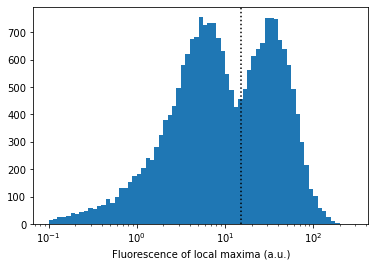

In [3]:
#### Select spots ####

sd1=1.; sd2=10.; cutoff=15;

## Compute band-passed image
imBpS=array([ndimage.filters.gaussian_filter(im,sd1)-ndimage.filters.gaussian_filter(im,sd2) for im in imS])

## Find local maxima
imMaxS=array([
      (imBp>roll(imBp, 1,axis=0))*\
      (imBp>roll(imBp,-1,axis=0))*\
      (imBp>roll(imBp, 1,axis=1))*\
      (imBp>roll(imBp,-1,axis=1))*\
      (imBp>roll(roll(imBp, 1,axis=0), 1,axis=1))*\
      (imBp>roll(roll(imBp, 1,axis=0),-1,axis=1))*\
      (imBp>roll(roll(imBp,-1,axis=0),-1,axis=1))*\
      (imBp>roll(roll(imBp,-1,axis=0), 1,axis=1))*1 for imBp in imBpS])

plt.figure();
plt.hist(imBpS[where(imMaxS*mask)],bins=10**r_[-1:2.5:.05])
plt.axvline(cutoff,c='k',ls=':'); plt.xscale('log'); plt.xlabel('Fluorescence of local maxima (a.u.)')
plt.show()

imMaxS=imMaxS*(imBpS>cutoff)*mask


<IPython.core.display.Javascript object>


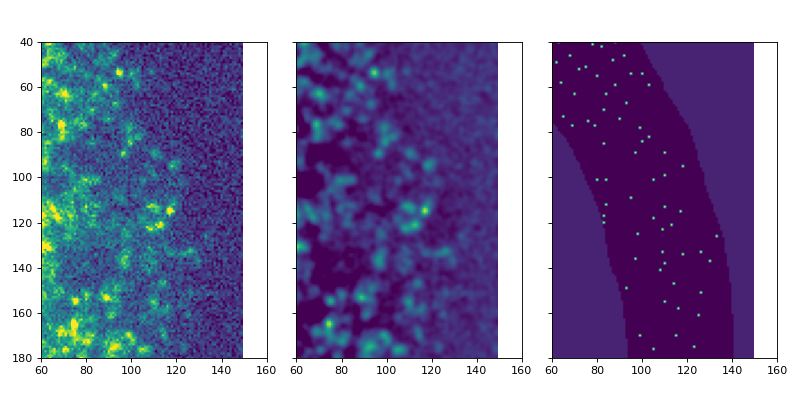

In [4]:
## Display
%matplotlib notebook
fig,ax=plt.subplots(1,3,sharex=True,sharey=True,figsize=(10,5))
plt.sca(ax[0]); plt.imshow(imS[0]); plt.clim(-10,150)
plt.sca(ax[1]); plt.imshow(imBpS[0]); plt.clim(-20,120)
plt.sca(ax[2]); plt.imshow(imMaxS[0]-mask*.1); #plt.clim(0,1)
plt.xlim(60,160); plt.ylim(180,40); 
plt.tight_layout()
plt.show()

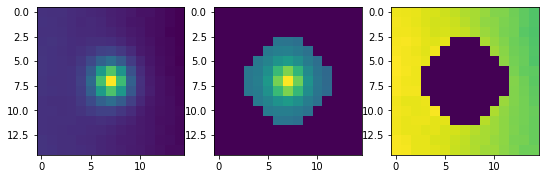

In [5]:
#### Define spot mask ####

r=4.2 # Radius of spot mask
w=7   # Size of window (half-width) around spots

## Make list of spot images
res=[]
for t,y,x in array(where(imMaxS)).T:
    res.append(roll(roll(imS[t],-x+w,axis=1),-y+w,axis=0)[:1+2*w][:,:1+2*w])
res=array(res)

## Compute mean spot image
meanSpot=res.mean(0)

## Compute and display spot mask
spotMask=(lambda x,y: x**2+y**2<r**2)(*meshgrid(r_[-w:w+1],r_[-w:w+1]))*1.
wMask=where(spotMask)
wNotMask=where(1-spotMask)
%matplotlib inline
fig,ax=plt.subplots(1,3,figsize=(9,3))
plt.sca(ax[0]); plt.imshow(meanSpot)
plt.sca(ax[1]); plt.imshow(meanSpot*spotMask)
plt.sca(ax[2]); plt.imshow(meanSpot*(1-spotMask))
plt.show()

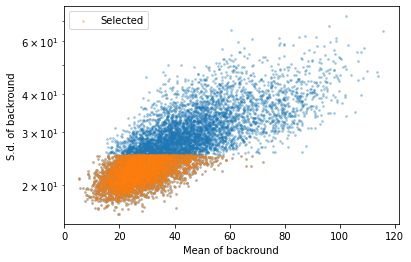

In [6]:
#### Select spots that are well isolated (i.e. where background is homogenous) ####

sdCutoff=8. *sqrt(10) # Note multiplying by sqrt(10) compared to the `Pos9` notebook, because `Pos9` uses an average of 10 images taken in nthe same imaging conditions as `Pos10`

meanAndSDofBackground=array([[mean(a[wNotMask]), var(a[wNotMask])**.5] for a in res])
sel=where(meanAndSDofBackground[:,1]<sdCutoff)[0]
plt.figure()
plt.scatter(meanAndSDofBackground[:,0],   meanAndSDofBackground[:,1],  alpha=.3, s=3)
plt.scatter(meanAndSDofBackground[sel,0], meanAndSDofBackground[sel,1],alpha=.3, s=3, label='Selected')
plt.yscale('log'); plt.legend()
plt.xlabel('Mean of backround'); plt.ylabel('S.d. of backround'); 
plt.show()


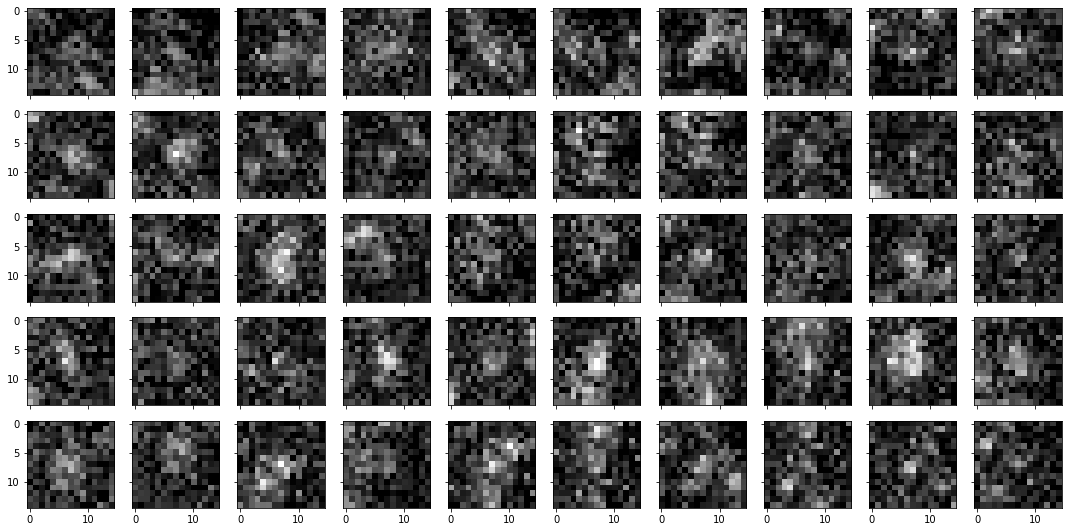

In [7]:
## Display first 50 spots
fig,ax=plt.subplots(5,10,sharex=True,sharey=True,figsize=(15,1.5*5))
ax_=ax.flatten()
for i,a in enumerate(res[sel][:ax_.shape[0]]):
    plt.sca(ax_[i])
    plt.imshow(a-median(a[wNotMask]),cmap='gray')
    plt.clim(-20,100)
plt.tight_layout()
plt.show()

In [8]:
fluoMask=   array([   sum(a[wMask])    for a in res[sel]]) # Summed ADUs in mask
fluoNotMask=array([median(a[wNotMask]) for a in res[sel]])*wMask[0].shape[0] # Estimated ADUs in mask coming from background

fluoSpots=fluoMask-fluoNotMask # Estimated ADUs coming from MNP

print("Spot intensity in 'standard' imaging conditions (exposure=100ms, SpectraX_Cyan=5, iXon_gain=30):")
print("  Mean:   %6.1f ADUs"%mean(fluoSpots))
print("  Median: %6.1f ADUs"%median(fluoSpots))

print("\nn = %d spots"%(fluoSpots.shape[0]))

Spot intensity in 'standard' imaging conditions (exposure=100ms, SpectraX_Cyan=5, iXon_gain=30):
  Mean:    832.8 ADUs
  Median:  730.4 ADUs

n = 4388 spots


sdCutoff = 20.0  =>  Median:  656.2 ADUs
sdCutoff = 21.0  =>  Median:  708.1 ADUs
sdCutoff = 22.0  =>  Median:  722.4 ADUs
sdCutoff = 23.0  =>  Median:  724.5 ADUs
sdCutoff = 25.0  =>  Median:  729.1 ADUs
sdCutoff = 30.0  =>  Median:  736.6 ADUs
sdCutoff = 35.0  =>  Median:  756.1 ADUs
sdCutoff = 40.0  =>  Median:  764.2 ADUs
sdCutoff = 50.0  =>  Median:  773.5 ADUs
sdCutoff = 60.0  =>  Median:  775.8 ADUs


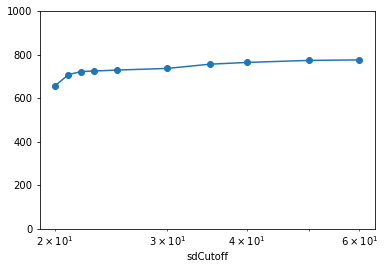

In [9]:
## Checking the effect of `sdCutoff` on the result
tmp=[]
for sdCutoff in [20, 21, 22, 23, 25, 30, 35, 40, 50, 60]:
    sel=where(meanAndSDofBackground[:,1]<sdCutoff)[0]
    tmp.append((sdCutoff, median(array([sum(a[wMask])-median(a[wNotMask])*wMask[0].shape[0] for a in res[sel]]))))
    print("sdCutoff = %.1f  =>  Median: %6.1f ADUs"%tmp[-1])
tmp=array(tmp)

plt.figure()
plt.plot(tmp[:,0], tmp[:,1], marker='o')
plt.ylim(0,1000); plt.xscale('log')
plt.xlabel('sdCutoff'); plt.xlabel('sdCutoff');
plt.show()


=> No major effect of `sdCutoff` on the result.